In [ ]:
# !pip install -U -q langchain openai ragas chromadb sentence-transformers

In [ ]:
# !pip install pypdf

In [ ]:
# !pip install datasets

In [ ]:
from langchain.document_loaders import PyPDFLoader
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.callbacks import get_openai_callback

In [ ]:
import getpass
import os
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

In [ ]:
b_docs = []

loader = PyPDFLoader('/content/drive/My Drive/bert.pdf')
b_docs.extend(loader.load())


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap = 100)

docs = text_splitter.split_documents(b_docs)
embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = Chroma.from_documents(docs, embeddings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
len(docs)

78

## 1. Vector Store Backed Retriever
A vector store retriever is a retriever that uses a vector store to retrieve documents.
It uses the search methods implemented by a vector store, like similarity search and MMR, to query the texts in the vector store.

In [ ]:
chroma_retriever = vectorstore.as_retriever(
        search_type="mmr", search_kwargs={"k": 4, "fetch_k": 10}
    )

In [ ]:
print(max([len(chunk.page_content) for chunk in docs]))

999


=============================================================================================

## Prompt template


In [ ]:
from langchain.prompts import ChatPromptTemplate
template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
Question: {question}
Context: {context}
Answer:
"""
prompt = ChatPromptTemplate.from_template(template)
# print(prompt)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks.\nUse the following pieces of retrieved context to answer the question.\nIf you don't know the answer, just say that you don't know.\nUse three sentences maximum and keep the answer concise.\nQuestion: {question}\nContext: {context}\nAnswer:\n"))])

## RAG Chain

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
rag_chain = (
    {"context": chroma_retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

query = "What are the two main tasks on which BERT is pre-trained on?"
rag_chain.invoke(query)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


'BERT is pre-trained on two main tasks: Masked Language Model (MLM) and Next Sentence Prediction (NSP). MLM involves predicting masked words in a sentence, while NSP involves determining if two sentences are consecutive in a document. These tasks enable BERT to learn bidirectional representations and improve performance on downstream tasks.'

## Rag Chain function

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

def rag_chain(retriever):
  llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
  rag_chain = (
      {"context": retriever, "question": RunnablePassthrough()}
      | prompt
      | llm
      | StrOutputParser()
  )
  return rag_chain

# query = "What are the two main tasks on which BERT is pre-trained on?"
# rag_chain.invoke(query)

## Ground Truths Dataset
Procured the ground truth dataset from the research paper, ARAGOG, https://arxiv.org/pdf/2404.01037

They used 13 papers and generated the ground truths using GPT-4, but here owing to limited resources, I have used one paper of BERT and used 8 samples of the original 107 samples.

In [ ]:
# questions= [
#         "What are the two main tasks BERT is pre-trained on?",
#         "What model sizes are reported for BERT, and what are their specifications?",
#         "How does BERT's architecture facilitate the use of a unified model across diverse NLP tasks?",
#         "How does BERT's performance on the GLUE benchmark compare to previous state-of-the-art models?",
#         "What significant improvements does BERT bring to the SQuAD v1.1,v2.0 and v13.5 tasks compared to prior models?",
#         "Explain how BERT uses the 'masked LM' (MLM) for its pre-training.",
#         "Discuss the impact of model size on BERT's performance across different tasks.",
#         "What datasets were used for BERT's pre-training and why?"
#     ]
# ground_truths = [
#         "Masked LM (MLM) and Next Sentence Prediction (NSP).",
#         "BERTBASE (L=12, H=768, A=12, Total Parameters=110M) and BERTLARGE (L=24, H=1024, A=16, Total Parameters=340M).",
#         "BERT uses a multi-layer bidirectional Transformer encoder architecture, allowing for minimal task-specific architecture modifications in fine-tuning.",
#         "BERT achieved new state-of-the-art on the GLUE benchmark (80.5%), surpassing the previous best models.",
#         "BERT set new records on SQuAD v1.1 and v2.0, significantly outperforming the top leaderboard systems at the time. Version 13.5 doesn't exist. ",
#         "In MLM, a percentage of input tokens are masked randomly, and the model predicts these masked tokens based on their context.",
#         "Larger BERT models consistently show better performance across tasks, indicating the importance of model size in achieving high accuracy.",
#         "BooksCorpus (800M words) and English Wikipedia (2500M words), chosen for their document-level organization and volume of data."
#          ]



In [ ]:
questions= [
        "What are the two main tasks BERT is pre-trained on?",
        "What model sizes are reported for BERT, and what are their specifications?",
        "How does BERT's architecture facilitate the use of a unified model across diverse NLP tasks?"
    ]
ground_truths = [
        "Masked LM (MLM) and Next Sentence Prediction (NSP).",
        "BERTBASE (L=12, H=768, A=12, Total Parameters=110M) and BERTLARGE (L=24, H=1024, A=16, Total Parameters=340M).",
        "BERT uses a multi-layer bidirectional Transformer encoder architecture, allowing for minimal task-specific architecture modifications in fine-tuning."
]



## Ragas Evaluation Metrics
I used the Ragas evaluation metrics from the paper, "RAGAS: Automated Evaluation of Retrieval Augmented Generation", [link](https://arxiv.org/pdf/2309.15217)

It defines 7 metrics to evaluate a RAG pipeline:
- **Retrieval metrics**: context precision, context recall, context relevancy
- **Generation metrics**: faithfulness, answer relevancy
- **End to end pipeline metrics**: answer similarity, answer correctness

In [ ]:
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    context_relevancy,
    answer_correctness,
    answer_similarity
)

from ragas.metrics.critique import harmfulness
from ragas import evaluate
from datasets import Dataset


In [ ]:
def create_raga_dataset(rag_chain, retriever):
  answers = []
  contexts = []

  for query in questions:
    answers.append(rag_chain.invoke(query))
    contexts.append([docs.page_content for docs in retriever.get_relevant_documents(query)])
  data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truth": ground_truths
  }
  dataset = Dataset.from_dict(data)
  return dataset

In [ ]:
def evaluate_ragas_dataset(ragas_dataset):
  result = evaluate(
    ragas_dataset,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
        context_relevancy,
        answer_correctness,
        answer_similarity
    ],
  )
  return result

## Evaluating Chroma retriever

In [ ]:
chroma_qa_chain = rag_chain(chroma_retriever)

In [ ]:
query = "What are the two main tasks on which BERT is pre-trained on?"
chroma_qa_chain.invoke(query)

"BERT is pre-trained on two main tasks: Masked Language Model (MLM) and Next Sentence Prediction (NSP). These tasks enable bidirectionality and improve the model's performance."

In [ ]:
chroma_dataset = create_raga_dataset(chroma_qa_chain, chroma_retriever)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [ ]:
chroma_result = evaluate_ragas_dataset(chroma_dataset)

Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
chroma_result

{'context_precision': 0.9201, 'faithfulness': 0.9062, 'answer_relevancy': 0.8138, 'context_recall': 0.8750, 'context_relevancy': 0.0313, 'answer_correctness': 0.7052, 'answer_similarity': 0.8956}

In [ ]:
all_results = []
all_results.append(chroma_result)

In [ ]:
chroma_df = chroma_result.to_pandas()
chroma_df.head()

,question,answer,contexts,ground_truth,context_precision,faithfulness,answer_relevancy,context_recall,context_relevancy,answer_correctness,answer_similarity
0,What are the two main tasks BERT is pre-traine...,BERT is pre-trained on two main tasks: Masked ...,[• GPT used the same learning rate of 5e-5 for...,Masked LM (MLM) and Next Sentence Prediction (...,0.805556,1.00,0.954348,1.0,0.000000,0.586239,0.844955
1,"What model sizes are reported for BERT, and wh...","BERT BASE contains 110M parameters, while BERT...","[For example, the largest Transformer explored...","BERTBASE (L=12, H=768, A=12, Total Parameters=...",1.000000,0.50,0.000000,1.0,0.017699,0.607835,0.931340
2,How does BERT's architecture facilitate the us...,BERT's architecture facilitates the use of a u...,[the need for many heavily-engineered task-\ns...,BERT uses a multi-layer bidirectional Transfor...,0.916667,1.00,0.896769,1.0,0.040816,0.728305,0.913221
3,How does BERT's performance on the GLUE benchm...,BERT's performance on the GLUE benchmark outpe...,"[reported GLUE task, MNLI, BERT obtains a 4.6%...",BERT achieved new state-of-the-art on the GLUE...,1.000000,1.00,0.973565,1.0,0.034483,0.654823,0.905007
4,What significant improvements does BERT bring ...,BERT brings significant improvements to the SQ...,[• GPT used the same learning rate of 5e-5 for...,"BERT set new records on SQuAD v1.1 and v2.0, s...",1.000000,0.75,0.931294,0.5,0.000000,0.781131,0.874503


In [ ]:
chroma_df.to_csv("chroma_retriever.csv")

====================================================================================================

## 2. Parent Document Retriever
One of the easier ways of improving a retriever is to embed our documents into small chunks, and then retrieve a significant amount of additional context that "surrounds" the found context.

You can read more about this method [here](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/parent_document_retriever/)!

The basic outline of this retrieval method is as follows:

- Obtain User Question
- Retrieve child documents using Dense Vector Retrieval
M- erge the child documents based on their parents. If they have the same parents, they become merged.
- Replace the child documents with their respective parent documents from an in-memory-store.
- Use the parent documents to augment generation.

In [ ]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore

parent_splitter = RecursiveCharacterTextSplitter(chunk_size=1500)
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

vectorstore = Chroma(collection_name="split_parents", embedding_function=embeddings)

store = InMemoryStore()

In [ ]:
parent_document_retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)

In [ ]:
parent_document_retriever.add_documents(b_docs)

## Evaluating Parent Document Retriever

In [ ]:
parent_qa_chain = rag_chain(parent_document_retriever)

In [ ]:
query = "What are the two main tasks on which BERT is pre-trained on?"
parent_qa_chain.invoke(query)

"BERT is pre-trained on the BooksCorpus and Wikipedia, which consist of a total of 3,300M words. The two main tasks on which BERT is pre-trained are the masked language model (MLM) and the next sentence prediction (NSP) task. These tasks enable bidirectionality and contribute significantly to the model's performance."

In [ ]:
pda_dataset = create_raga_dataset(parent_qa_chain, parent_document_retriever)

In [ ]:
pda_result = evaluate_ragas_dataset(pda_dataset)

Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
pda_result

{'context_precision': 0.9167, 'faithfulness': 1.0000, 'answer_relevancy': 0.9169, 'context_recall': 0.9018, 'context_relevancy': 0.0226, 'answer_correctness': 0.7600, 'answer_similarity': 0.8820}

In [ ]:
# all_results = []
all_results.append(pda_result)

In [ ]:
all_results

[{'context_precision': 0.9201, 'faithfulness': 0.9062, 'answer_relevancy': 0.8138, 'context_recall': 0.8750, 'context_relevancy': 0.0313, 'answer_correctness': 0.7052, 'answer_similarity': 0.8956},
 {'context_precision': 0.9167, 'faithfulness': 1.0000, 'answer_relevancy': 0.9169, 'context_recall': 0.9018, 'context_relevancy': 0.0226, 'answer_correctness': 0.7600, 'answer_similarity': 0.8820}]

In [ ]:
pda_df = pda_result.to_pandas()
pda_df.head()

,question,answer,contexts,ground_truth,context_precision,faithfulness,answer_relevancy,context_recall,context_relevancy,answer_correctness,answer_similarity
0,What are the two main tasks BERT is pre-traine...,BERT is pre-trained on the BooksCorpus and Wik...,[between how BERT and GPT were trained:\n• GPT...,Masked LM (MLM) and Next Sentence Prediction (...,1.000000,1.0,0.932955,0.714286,0.000000,0.802006,0.808024
1,"What model sizes are reported for BERT, and wh...",Two model sizes are reported for BERT: BERT BA...,[of Transformers has become common and our im-...,"BERTBASE (L=12, H=768, A=12, Total Parameters=...",1.000000,1.0,0.946293,1.000000,0.010204,0.610601,0.942403
2,How does BERT's architecture facilitate the us...,BERT's architecture facilitates the use of a u...,[word based only on its context. Unlike left-t...,BERT uses a multi-layer bidirectional Transfor...,1.000000,1.0,0.932509,1.000000,0.025641,0.869800,0.907773
3,How does BERT's performance on the GLUE benchm...,BERT BASE and BERT LARGE outperform all system...,[best model on the Dev set. With random restar...,BERT achieved new state-of-the-art on the GLUE...,1.000000,1.0,0.901840,1.000000,0.045455,0.471662,0.886649
4,What significant improvements does BERT bring ...,BERT brings significant improvements to the SQ...,[best model on the Dev set. With random restar...,"BERT set new records on SQuAD v1.1 and v2.0, s...",0.833333,1.0,0.931294,0.500000,0.031746,0.786231,0.894923


In [ ]:
pda_df.to_csv("parent_document_retriever.csv")

## 3. Ensemble Retriever (Dense + sparse embeddings)


Official Documentation [here](https://python.langchain.com/docs/modules/data_connection/retrievers/ensemble)!

The basic idea is as follows:

1. Obtain User Question
2. Hit the Retriever Pair
    - Retrieve Documents with BM25 Sparse Vector Retrieval
    - Retrieve Documents with Dense Vector Retrieval Method
3. Collect and "fuse" the retrieved docs based on their weighting using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm into a single ranked list.
4. Use those documents to augment our generation.



In [ ]:
!pip install -q -U rank_bm25

In [ ]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever

text_splitter = RecursiveCharacterTextSplitter(chunk_size=450, chunk_overlap=75)
docs = text_splitter.split_documents(b_docs)

bm25_retriever = BM25Retriever.from_documents(docs)
bm25_retriever.k = 2

vectorstore = Chroma.from_documents(docs, embeddings)
chroma_retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, chroma_retriever], weights=[0.75, 0.25])

## Evaluating Ensemble Retriever

In [ ]:
ensemble_bm25_qa_chain = rag_chain(ensemble_retriever)

In [ ]:
ensemble_bm25_dataset = create_raga_dataset(ensemble_bm25_qa_chain, ensemble_retriever)

In [ ]:
query = "What are the two main tasks on which BERT is pre-trained on?"
ensemble_bm25_qa_chain.invoke(query)

'BERT is pre-trained on two main tasks: pre-training and fine-tuning. During pre-training, the model is trained on unlabeled data over different pre-training tasks, while fine-tuning involves initializing the BERT model with pre-trained parameters and fine-tuning all parameters using labeled data from downstream tasks.'

In [ ]:
ensemble_bm25_result = evaluate_ragas_dataset(ensemble_bm25_dataset)

Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
ensemble_bm25_result

{'context_precision': 0.8807, 'faithfulness': 1.0000, 'answer_relevancy': 0.9203, 'context_recall': 0.8750, 'context_relevancy': 0.0660, 'answer_correctness': 0.6833, 'answer_similarity': 0.8660}

In [ ]:
all_results.append(ensemble_bm25_result)

In [ ]:
ensemble_bm25_df = ensemble_bm25_result.to_pandas()
ensemble_bm25_df.head()

,question,answer,contexts,ground_truth,context_precision,faithfulness,answer_relevancy,context_recall,context_relevancy,answer_correctness,answer_similarity
0,What are the two main tasks BERT is pre-traine...,BERT is pre-trained on unlabeled data over dif...,[3 BERT\nWe introduce BERT and its detailed im...,Masked LM (MLM) and Next Sentence Prediction (...,0.833333,1.0,0.998159,1.0,0.037736,0.490276,0.761103
1,"What model sizes are reported for BERT, and wh...",The reported model sizes for BERT are BERT BAS...,"[model, single task. F1 scores are reported fo...","BERTBASE (L=12, H=768, A=12, Total Parameters=...",0.950000,1.0,0.949461,1.0,0.275862,0.896093,0.917705
2,How does BERT's architecture facilitate the us...,BERT's architecture allows for fine-tuning on ...,"[(GLUE) benchmark (Wang et al., 2018a) is a co...",BERT uses a multi-layer bidirectional Transfor...,1.000000,1.0,0.914433,1.0,0.063830,0.722742,0.890970
3,How does BERT's performance on the GLUE benchm...,BERT's performance on the GLUE benchmark signi...,[is that few parameters need to be learned fro...,BERT achieved new state-of-the-art on the GLUE...,0.679167,1.0,0.941220,0.5,0.085106,0.479565,0.918259
4,What significant improvements does BERT bring ...,BERT brings significant improvements to tasks ...,[mixed results on the downstream task impact o...,"BERT set new records on SQuAD v1.1 and v2.0, s...",1.000000,1.0,0.931294,0.5,0.000000,0.596304,0.885215


In [ ]:
ensemble_bm25_df.to_csv("ensemble_bm25_retriever.csv")

## 4. ColBERT Retriever
ColBERT: Contextualized Late Interaction over BERT

Late Interaction: Unlike traditional dense retrievers that compute a single fixed size vector representation for entire queries and documents, ColBERT maitains separate fine grained embeddings for each token in the query and the document. It then performs a "late" interaction between the embeddings, allowing for more nuanced and precise similarity calculations.

Official Documentation [here](https://github.com/stanford-futuredata/ColBERT)

In [ ]:
# !pip install -U ragatouille --quiet

In [ ]:
from ragatouille import RAGPretrainedModel

r_docs = loader.load_and_split()

RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
ragatouille_docs = [str(doc) for doc in r_docs]

RAG.index(
  collection=ragatouille_docs,
  index_name="langchain-index",
  max_document_length=512,
  split_documents=True,
)


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[May 09, 12:56:10] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[May 09, 12:56:57] #> Creating directory .ragatouille/colbert/indexes/langchain-index 




/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[May 09, 12:56:59] [0] 		 #> Encoding 54 passages..


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 2/2 [02:16<00:00, 68.07s/it]

[May 09, 12:59:15] [0] 		 avg_doclen_est = 301.96295166015625 	 len(local_sample) = 54
[May 09, 12:59:15] [0] 		 Creating 1,024 partitions.
[May 09, 12:59:15] [0] 		 *Estimated* 16,305 embeddings.
[May 09, 12:59:15] [0] 		 #> Saving the indexing plan to .ragatouille/colbert/indexes/langchain-index/plan.json ..


used 20 iterations (9.144s) to cluster 15491 items into 1024 clusters
[0.036, 0.035, 0.032, 0.032, 0.032, 0.037, 0.034, 0.032, 0.033, 0.035, 0.031, 0.034, 0.035, 0.037, 0.035, 0.035, 0.032, 0.036, 0.035, 0.035, 0.034, 0.035, 0.034, 0.035, 0.034, 0.033, 0.034, 0.034, 0.037, 0.037, 0.034, 0.039, 0.034, 0.033, 0.033, 0.031, 0.035, 0.035, 0.033, 0.04, 0.036, 0.035, 0.033, 0.037, 0.035, 0.033, 0.033, 0.039, 0.035, 0.033, 0.033, 0.035, 0.038, 0.037, 0.035, 0.036, 0.041, 0.034, 0.04, 0.033, 0.034, 0.039, 0.037, 0.039, 0.037, 0.036, 0.034, 0.032, 0.029, 0.037, 0.036, 0.032, 0.036, 0.034, 0.04, 0.035, 0.035, 0.036, 0.037, 0.036, 0.037, 0.037, 0.036, 0.035, 0.033, 0.033, 0.034, 0.036, 0.032, 0.038, 0.033, 0.037, 0.033, 0.035, 0.034, 0.035, 0.036, 0.034, 0.036, 0.034, 0.037, 0.037, 0.034, 0.036, 0.033, 0.031, 0.035, 0.033, 0.035, 0.03, 0.035, 0.034, 0.038, 0.032, 0.036, 0.033, 0.037, 0.036, 0.032, 0.035, 0.035, 0.033, 0.034, 0.04, 0.034, 0.041, 0.036, 0.032]


0it [00:00, ?it/s]

[May 09, 12:59:24] [0] 		 #> Encoding 54 passages..



100%|██████████| 2/2 [02:12<00:00, 66.37s/it]
1it [02:13, 133.40s/it]
100%|██████████| 1/1 [00:00<00:00, 917.39it/s]

[May 09, 13:01:38] #> Optimizing IVF to store map from centroids to list of pids..
[May 09, 13:01:38] #> Building the emb2pid mapping..
[May 09, 13:01:38] len(emb2pid) = 16306



100%|██████████| 1024/1024 [00:00<00:00, 23272.02it/s]

[May 09, 13:01:38] #> Saved optimized IVF to .ragatouille/colbert/indexes/langchain-index/ivf.pid.pt
Done indexing!


'.ragatouille/colbert/indexes/langchain-index'

In [ ]:
RAG = RAGPretrainedModel.from_index(".ragatouille/colbert/indexes/langchain-index")
ragatouille_retriever = RAG.as_langchain_retriever(k=10)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
ragatouille_qa_chain = rag_chain(ragatouille_retriever)

In [ ]:
ragatouille_dataset = create_raga_dataset(ragatouille_qa_chain, ragatouille_retriever)

Loading searcher for index langchain-index for the first time... This may take a few seconds


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[May 09, 13:07:07] #> Loading codec...
[May 09, 13:07:07] #> Loading IVF...
[May 09, 13:07:07] Loading segmented_lookup_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


[May 09, 13:07:50] #> Loading doclens...


100%|██████████| 1/1 [00:00<00:00, 2559.06it/s]

[May 09, 13:07:50] #> Loading codes and residuals...



100%|██████████| 1/1 [00:00<00:00, 129.15it/s]

[May 09, 13:07:50] Loading filter_pids_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


[May 09, 13:08:25] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . What are the two main tasks BERT is pre-trained on?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2024,  1996,  2048,  2364,  8518, 14324,  2003,
         3653,  1011,  4738,  2006,  1029,   102,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda'

In [ ]:
query = "What are the two main tasks on which BERT is pre-trained on?"
ragatouille_qa_chain.invoke(query)

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


'BERT is pre-trained on two main tasks: the Masked LM task, where some tokens are masked and predicted, and the Next Sentence Prediction (NSP) task, where the model predicts if two sentences follow each other in the original text. These pre-training tasks enable BERT to learn bidirectional representations and achieve state-of-the-art results on various downstream tasks.'

In [ ]:
colbert_docs = ragatouille_retriever.invoke(query)
pretty_print_docs(colbert_docs)

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Document 1:

There are two steps in our\nframework: pre-training and ﬁne-tuning . Dur-\ning pre-training, the model is trained on unlabeled\ndata over different pre-training tasks. For ﬁne-\ntuning, the BERT model is ﬁrst initialized with\nthe pre-trained parameters, and all of the param-\neters are ﬁne-tuned using labeled data from the\ndownstream tasks. Each downstream task has sep-\narate ﬁne-tuned models, even though they are ini-\ntialized with the same pre-trained parameters. The\nquestion-answering example in Figure 1 will serve\nas a running example for this section.\nA distinctive feature of BERT is its uniﬁed ar-\nchitecture across different tasks. There is mini-mal difference between the pre-trained architec-\nture and the ﬁnal downstream architecture.\nModel Architecture BERT’s model architec-\nture is a multi-layer bidirectional Transformer en-\ncoder based on the original implementation de-\nscribed in Vaswani et al. (2017) and released in\nthetensor2tensor library.1Becau

In [ ]:
ragatouille_dataset[0]

{'question': 'What are the two main tasks BERT is pre-trained on?',
 'answer': 'BERT is pre-trained on two main tasks: the Masked LM task and the Next Sentence Prediction (NSP) task. The Masked LM task involves predicting masked tokens in a sequence, while the NSP task focuses on predicting whether two sentences follow each other. These pre-training tasks enable BERT to learn bidirectional representations from unlabeled text data.',
 'contexts': ['There are two steps in our\\nframework: pre-training and ﬁne-tuning . Dur-\\ning pre-training, the model is trained on unlabeled\\ndata over different pre-training tasks. For ﬁne-\\ntuning, the BERT model is ﬁrst initialized with\\nthe pre-trained parameters, and all of the param-\\neters are ﬁne-tuned using labeled data from the\\ndownstream tasks. Each downstream task has sep-\\narate ﬁne-tuned models, even though they are ini-\\ntialized with the same pre-trained parameters. The\\nquestion-answering example in Figure 1 will serve\\nas a ru

## 5. MultiQuery Retriever
Official Documentation [here](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/MultiQueryRetriever/)

The **MultiQueryRetriever** automates the process of prompt tuning by using an LLM to generate multiple queries from different perspectives for a given user input query.
- For each query, it retrieves a set of relevant documents and takes the unique union across all queries to get a larger set of potentially relevant documents.
- By generating multiple perspectives on the same question, the MultiQueryRetriever might be able to overcome some of the limitations of the distance-based retrieval and get a richer set of results.

In [ ]:
from langchain.retrievers.multi_query import MultiQueryRetriever
multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=vectorstore.as_retriever(), llm=llm
)

In [ ]:
m_docs = multi_query_retriever.invoke(query)
pretty_print_docs(m_docs)

Document 1:

• GPT used the same learning rate of 5e-5 for
all ﬁne-tuning experiments; BERT chooses a
task-speciﬁc ﬁne-tuning learning rate which
performs the best on the development set.To isolate the effect of these differences, we per-
form ablation experiments in Section 5.1 which
demonstrate that the majority of the improvements
are in fact coming from the two pre-training tasks
and the bidirectionality they enable.
A.5 Illustrations of Fine-tuning on Different
Tasks
The illustration of ﬁne-tuning BERT on different
tasks can be seen in Figure 4. Our task-speciﬁc
models are formed by incorporating BERT with
one additional output layer, so a minimal num-
ber of parameters need to be learned from scratch.
Among the tasks, (a) and (b) are sequence-level
tasks while (c) and (d) are token-level tasks. In
the ﬁgure,Erepresents the input embedding, Ti
represents the contextual representation of token i,
[CLS] is the special symbol for classiﬁcation out-
-----------------------------------

In [ ]:
multi_query_qa_chain = rag_chain(multi_query_retriever)

In [ ]:
query = "What are the two main tasks on which BERT is pre-trained on?"
multi_query_qa_chain.invoke(query)

'BERT is pre-trained on two main tasks: Masked Language Model (MLM) and Next Sentence Prediction (NSP). These tasks help BERT learn the contextual relationships between words and sentences.'

In [ ]:
multi_query_dataset = create_raga_dataset(multi_query_qa_chain, multi_query_retriever)

In [ ]:
multi_query_result = evaluate_ragas_dataset(multi_query_dataset)

Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
multi_query_result

{'context_precision': 0.9165, 'faithfulness': 0.9437, 'answer_relevancy': 0.9445, 'context_recall': 0.7500, 'context_relevancy': 0.0368, 'answer_correctness': 0.6984, 'answer_similarity': 0.8863}

In [ ]:
all_results.append(multi_query_result)
multi_query_df = multi_query_result.to_pandas()
multi_query_df.head()



,question,answer,contexts,ground_truth,context_precision,faithfulness,answer_relevancy,context_recall,context_relevancy,answer_correctness,answer_similarity
0,What are the two main tasks BERT is pre-traine...,BERT is pre-trained on unlabeled data over dif...,[3 BERT\nWe introduce BERT and its detailed im...,Masked LM (MLM) and Next Sentence Prediction (...,0.916667,1.0,0.998159,1.0,0.024390,0.491368,0.765472
1,"What model sizes are reported for BERT, and wh...",The reported model sizes for BERT are BERT BAS...,[we will omit an exhaustive background descrip...,"BERTBASE (L=12, H=768, A=12, Total Parameters=...",1.000000,0.8,0.949461,0.5,0.013699,0.536428,0.945712
2,How does BERT's architecture facilitate the us...,BERT's architecture allows for a unified model...,"[range of tasks, such as question answering an...",BERT uses a multi-layer bidirectional Transfor...,1.000000,1.0,0.902549,1.0,0.037037,0.869929,0.908288
3,How does BERT's performance on the GLUE benchm...,BERT's performance on the GLUE benchmark outpe...,[tention masking. For the largest and most wid...,BERT achieved new state-of-the-art on the GLUE...,1.000000,1.0,0.961370,0.5,0.038462,0.654893,0.905286
4,What significant improvements does BERT bring ...,BERT brings significant improvements to the SQ...,[Published\nunet (Ensemble) - - 71.4 74.9\nSLQ...,"BERT set new records on SQuAD v1.1 and v2.0, s...",0.734524,1.0,0.982522,0.5,0.047619,0.721313,0.885250


In [ ]:
multi_query_df.to_csv("multi_query_retriever.csv")

## 6. Cohere Reranker

Given a base retriever that will fetch relevant documents, say top 20 documents, we will use Cohere reranker to rerank the documents and fetch only the top 3 most relevant documents.
- uses the idea of contextual compression, [link](https://blog.langchain.dev/improving-document-retrieval-with-contextual-compression/).

In [ ]:
# !pip install --upgrade --quiet  cohere

In [ ]:
# !pip install langchain-cohere

In [ ]:
import getpass
import os

os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

Cohere API Key:··········


In [ ]:
chroma_rerank_retriever = vectorstore.as_retriever(
        search_type="mmr", search_kwargs={"k": 15}
    )

In [ ]:
cc_docs = chroma_rerank_retriever.invoke(query)
pretty_print_docs(cc_docs)

Document 1:

• GPT used the same learning rate of 5e-5 for
all ﬁne-tuning experiments; BERT chooses a
task-speciﬁc ﬁne-tuning learning rate which
performs the best on the development set.To isolate the effect of these differences, we per-
form ablation experiments in Section 5.1 which
demonstrate that the majority of the improvements
are in fact coming from the two pre-training tasks
and the bidirectionality they enable.
A.5 Illustrations of Fine-tuning on Different
Tasks
The illustration of ﬁne-tuning BERT on different
tasks can be seen in Figure 4. Our task-speciﬁc
models are formed by incorporating BERT with
one additional output layer, so a minimal num-
ber of parameters need to be learned from scratch.
Among the tasks, (a) and (b) are sequence-level
tasks while (c) and (d) are token-level tasks. In
the ﬁgure,Erepresents the input embedding, Ti
represents the contextual representation of token i,
[CLS] is the special symbol for classiﬁcation out-
-----------------------------------

In [ ]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank
from langchain_community.llms import Cohere

llm = Cohere(temperature=0)
compressor = CohereRerank()
cohere_compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=chroma_rerank_retriever
)


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `Cohere` was deprecated in LangChain 0.1.14 and will be removed in 0.3.0. An updated version of the class exists in the langchain-cohere package and should be used instead. To use it run `pip install -U langchain-cohere` and import as `from langchain_cohere import Cohere`.
  warn_deprecated(


In [ ]:
c_docs = cohere_compression_retriever.invoke(query)
pretty_print_docs(c_docs)

Document 1:

Dev Set
Tasks MNLI-m QNLI MRPC SST-2 SQuAD
(Acc) (Acc) (Acc) (Acc) (F1)
BERT BASE 84.4 88.4 86.7 92.7 88.5
No NSP 83.9 84.9 86.5 92.6 87.9
LTR & No NSP 82.1 84.3 77.5 92.1 77.8
+ BiLSTM 82.1 84.1 75.7 91.6 84.9
Table 5: Ablation over the pre-training tasks using the
BERT BASE architecture. “No NSP” is trained without
the next sentence prediction task. “LTR & No NSP” is
trained as a left-to-right LM without the next sentence
prediction, like OpenAI GPT. “+ BiLSTM” adds a ran-
domly initialized BiLSTM on top of the “LTR + No
NSP” model during ﬁne-tuning.
ablation studies can be found in Appendix C.
5.1 Effect of Pre-training Tasks
We demonstrate the importance of the deep bidi-
rectionality of BERT by evaluating two pre-
training objectives using exactly the same pre-
training data, ﬁne-tuning scheme, and hyperpa-
rameters as BERT BASE :
No NSP : A bidirectional model which is trained
using the “masked LM” (MLM) but without the
“next sentence prediction” (NSP) task.
--------

In [ ]:
cohere_compression_qa_chain = rag_chain(cohere_compression_retriever)

In [ ]:
cohere_compression_qa_chain.invoke(query)

'BERT is pre-trained on two main tasks: Masked Language Model (MLM) and Next Sentence Prediction (NSP). MLM involves predicting masked words in a sentence, while NSP focuses on predicting if two sentences are consecutive or not. These tasks help BERT understand language context and relationships between sentences.'

In [ ]:
cohere_compression_dataset = create_raga_dataset(cohere_compression_qa_chain, cohere_compression_retriever)

In [ ]:
cohere_compression_result = evaluate_ragas_dataset(cohere_compression_dataset)
cohere_compression_result
all_results.append(cohere_compression_result)
cohere_compression_df = cohere_compression_result.to_pandas()
cohere_compression_df.head()
cohere_compression_df.to_csv("cohere_compression_retriever.csv")

## 7. Mutiquery + Cohere Reranker


In [ ]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank
from langchain_community.llms import Cohere

llm = Cohere(temperature=0)
compressor = CohereRerank()
multiquery_cohere_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=multi_query_retriever
)


In [ ]:
multiquery_cohere_qa_chain = rag_chain(multiquery_cohere_retriever)

In [ ]:
mmdocs = multiquery_cohere_retriever.invoke(query)
pretty_print_docs(mmdocs)

Document 1:

ing and auto-encoder objectives have been used
for pre-training such models (Howard and Ruder,
2018; Radford et al., 2018; Dai and Le, 2015).
2.3 Transfer Learning from Supervised Data
There has also been work showing effective trans-
fer from supervised tasks with large datasets, such
as natural language inference (Conneau et al.,
2017) and machine translation (McCann et al.,
2017). Computer vision research has also demon-
strated the importance of transfer learning from
large pre-trained models, where an effective recipe
is to ﬁne-tune models pre-trained with Ima-
geNet (Deng et al., 2009; Yosinski et al., 2014).
3 BERT
We introduce BERT and its detailed implementa-
tion in this section. There are two steps in our
framework: pre-training and ﬁne-tuning . Dur-
ing pre-training, the model is trained on unlabeled
data over different pre-training tasks. For ﬁne-
tuning, the BERT model is ﬁrst initialized with
the pre-trained parameters, and all of the param-
----------------

In [ ]:
multiquery_cohere_qa_chain.invoke(query)

'BERT is pre-trained on two main tasks: pre-training and fine-tuning. During pre-training, the model is trained on unlabeled data over different pre-training tasks. Fine-tuning involves initializing the BERT model with pre-trained parameters for specific tasks.'

In [ ]:
multiquery_cohere_dataset = create_raga_dataset(multiquery_cohere_qa_chain, multiquery_cohere_retriever)

In [ ]:
multiquery_cohere_result = evaluate_ragas_dataset(multiquery_cohere_dataset)
multiquery_cohere_result
all_results.append(multiquery_cohere_result)
multiquery_cohere_df = multiquery_cohere_result.to_pandas()
multiquery_cohere_df.head()
multiquery_cohere_df.to_csv("multiquery_cohere_retriever.csv")

## 8. Contextual Compression Retriever

In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain_openai import OpenAI

llm = OpenAI(temperature=0)
compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=chroma_retriever
)



In [ ]:
compressed_docs = compression_retriever.invoke(query)
pretty_print_docs(compressed_docs)

Document 1:

- "the two pre-training tasks" 
- "the bidirectionality they enable"
----------------------------------------------------------------------------------------------------
Document 2:

- pre-training
- two steps in our framework: pre-training and ﬁne-tuning
- During pre-training, the model is trained on unlabeled data over different pre-training tasks.
----------------------------------------------------------------------------------------------------
Document 3:

BERT representations are jointly conditioned on both left and right context in all layers.
----------------------------------------------------------------------------------------------------
Document 4:

we pre-train BERT using two unsuper-
vised tasks, described in this section. This step
is presented in the left part of Figure 1.
Task #1: Masked LM Intuitively, it is reason-
able to believe that a deep bidirectional model is
strictly more powerful than either a left-to-right


In [ ]:
compression_qa_chain = rag_chain(compression_retriever)

In [ ]:
compression_qa_chain.invoke("How does BERT's architecture facilitate the use of a unified model across diverse NLP tasks?")

"BERT's architecture facilitates the use of a unified model across diverse NLP tasks by having minimal differences between the pre-trained architecture and the final downstream architecture. Each downstream task has separate fine-tuned models, even though they are initialized with the same pre-trained parameters. BERT's multi-layer bidirectional Transformer encoder allows for state-of-the-art performance on various NLP tasks."

In [ ]:
compression_dataset = create_raga_dataset(compression_qa_chain, compression_retriever)

In [ ]:
compression_result = evaluate_ragas_dataset(compression_dataset)
compression_result

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

{'context_precision': 1.0000, 'faithfulness': 0.9333, 'answer_relevancy': 0.9296, 'context_recall': 0.8333, 'context_relevancy': 0.0306, 'answer_correctness': 0.6561, 'answer_similarity': 0.8911}

In [ ]:
compression_df = compression_result.to_pandas()
compression_df.head()
compression_df.to_csv("compression_retriever.csv")

## 9. Cross Encoder Reranker

In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

chroma_cross_retriever = vectorstore.as_retriever(
        search_type="mmr", search_kwargs={"k": 15}
    )

model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-base")
compressor = CrossEncoderReranker(model=model, top_n=3)
cross_encoder_compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=chroma_cross_retriever
)

compressed_docs = cross_encoder_compression_retriever.invoke(query)
pretty_print_docs(compressed_docs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Document 1:

BERT is conceptually simple and empirically
powerful. It obtains new state-of-the-art re-
sults on eleven natural language processing
tasks, including pushing the GLUE score to
80.5% (7.7% point absolute improvement),
MultiNLI accuracy to 86.7% (4.6% absolute
improvement), SQuAD v1.1 question answer-
ing Test F1 to 93.2 (1.5 point absolute im-
provement) and SQuAD v2.0 Test F1 to 83.1
(5.1 point absolute improvement).
1 Introduction
Language model pre-training has been shown to
be effective for improving many natural language
processing tasks (Dai and Le, 2015; Peters et al.,
2018a; Radford et al., 2018; Howard and Ruder,
2018). These include sentence-level tasks such as
natural language inference (Bowman et al., 2015;
Williams et al., 2018) and paraphrasing (Dolan
and Brockett, 2005), which aim to predict the re-
lationships between sentences by analyzing them
holistically, as well as token-level tasks such as
named entity recognition and question answering,
-------------

In [ ]:
cross_encoder_compression_qa_chain = rag_chain(cross_encoder_compression_retriever)

In [ ]:
cross_encoder_compression_qa_chain.invoke(query)

'BERT is pre-trained on two main tasks: masked language modeling (MLM) and next sentence prediction (NSP). These tasks help BERT learn the relationships between words in a sentence and understand the context between two sentences.'

In [ ]:
query = "How does BERT's architecture facilitate the use of a unified model across diverse NLP tasks?"

In [ ]:
cross_encoder_compression_qa_chain.invoke(query)

"BERT's architecture allows for fine-tuning with labeled data from downstream tasks, resulting in separate fine-tuned models for each task. Despite this, the pre-trained parameters are the same for all models. The unified architecture of BERT minimizes the difference between pre-trained and downstream architectures, making it versatile across various NLP tasks."

In [ ]:
cross_encoder_compression_dataset = create_raga_dataset(cross_encoder_compression_qa_chain, cross_encoder_compression_retriever)

In [ ]:
cross_encoder_compression_result = evaluate_ragas_dataset(cross_encoder_compression_dataset)
cross_encoder_compression_result

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

{'context_precision': 1.0000, 'faithfulness': 1.0000, 'answer_relevancy': 0.9380, 'context_recall': 0.8333, 'context_relevancy': 0.0306, 'answer_correctness': 0.7030, 'answer_similarity': 0.8881}

In [ ]:
cross_encoder_compression_df = cross_encoder_compression_result.to_pandas()
cross_encoder_compression_df.head()
cross_encoder_compression_df.to_csv("cross_encoder_compression.csv")

## All Results

In [ ]:
chroma_result, pda_result, ensemble_bm25_result, multi_query_result

({'context_precision': 0.9201, 'faithfulness': 0.9062, 'answer_relevancy': 0.8138, 'context_recall': 0.8750, 'context_relevancy': 0.0313, 'answer_correctness': 0.7052, 'answer_similarity': 0.8956},
 {'context_precision': 0.9167, 'faithfulness': 1.0000, 'answer_relevancy': 0.9169, 'context_recall': 0.9018, 'context_relevancy': 0.0226, 'answer_correctness': 0.7600, 'answer_similarity': 0.8820},
 {'context_precision': 0.8807, 'faithfulness': 1.0000, 'answer_relevancy': 0.9203, 'context_recall': 0.8750, 'context_relevancy': 0.0660, 'answer_correctness': 0.6833, 'answer_similarity': 0.8660},
 {'context_precision': 0.9165, 'faithfulness': 0.9437, 'answer_relevancy': 0.9445, 'context_recall': 0.7500, 'context_relevancy': 0.0368, 'answer_correctness': 0.6984, 'answer_similarity': 0.8863})

In [ ]:
compression_result, cross_encoder_compression_result

({'context_precision': 1.0000, 'faithfulness': 0.9333, 'answer_relevancy': 0.9296, 'context_recall': 0.8333, 'context_relevancy': 0.0306, 'answer_correctness': 0.6561, 'answer_similarity': 0.8911},
 {'context_precision': 1.0000, 'faithfulness': 1.0000, 'answer_relevancy': 0.9380, 'context_recall': 0.8333, 'context_relevancy': 0.0306, 'answer_correctness': 0.7030, 'answer_similarity': 0.8881})

In [ ]:
def create_df_dict(pipeline_name, pipeline_items):
  df_dict = {"name" : pipeline_name}
  for name, score in pipeline_items:
    df_dict[name] = score
  return df_dict

In [ ]:
chroma_df_dict = create_df_dict("Chroma", chroma_result.items())

In [ ]:
pda_dict = create_df_dict("Parent Document", pda_result.items())
ensemble_dict = create_df_dict("Ensemble BM25", ensemble_bm25_result.items())
multiquery_dict = create_df_dict("MultiQuery", multi_query_result.items())
context_comp_dict = create_df_dict("Context Compressionr", compression_result.items())
cross_enc_rera_dict = create_df_dict("Cross Encoder Reranker", cross_encoder_compression_result.items())

In [ ]:
import pandas as pd
results_df = pd.DataFrame([chroma_df_dict, pda_dict, ensemble_dict, multiquery_dict, context_comp_dict, cross_enc_rera_dict
                           ])

In [ ]:
results_df

,name,context_precision,faithfulness,answer_relevancy,context_recall,context_relevancy,answer_correctness,answer_similarity
0,Chroma,0.9201,0.906200,0.813800,0.875000,0.031300,0.705200,0.895600
1,Parent Document,0.9167,1.000000,0.916900,0.901800,0.022600,0.760000,0.882000
2,Ensemble BM25,0.8807,1.000000,0.920300,0.875000,0.066000,0.683300,0.866000
3,MultiQuery,0.9165,0.943700,0.944500,0.750000,0.036800,0.698400,0.886300
4,Context Compressionr,1.0000,0.933333,0.929567,0.833333,0.030646,0.656128,0.891121
5,Cross Encoder Reranker,1.0000,1.000000,0.938041,0.833333,0.030646,0.702988,0.888144


In [ ]:
results_df.to_csv("results.csv")

In [ ]:
# !pip install wandb

In [ ]:
# !wandb login

In [ ]:
import pandas as pd
import wandb
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
data = pd.read_csv('results.csv')

# Initialize wandb
wandb.init(project='RAGS')

# Iterate over each metric and create bar plots
metrics = ['context_precision', 'faithfulness', 'answer_relevancy',
           'context_recall', 'context_relevancy', 'answer_correctness',
           'answer_similarity']

for metric in metrics:
    plt.figure(figsize=(8, 6))
    plt.bar(data['name'], data[metric], align='center', alpha=0.7)
    plt.title(f'{metric} vs. Retriever Index')
    plt.xlabel('Retriever Index')
    plt.ylabel(metric)
    plt.grid(True)

    # Log the plot to wandb
    wandb.log({f'{metric}_plot': wandb.Image(plt)})
    plt.close()

wandb.finish()


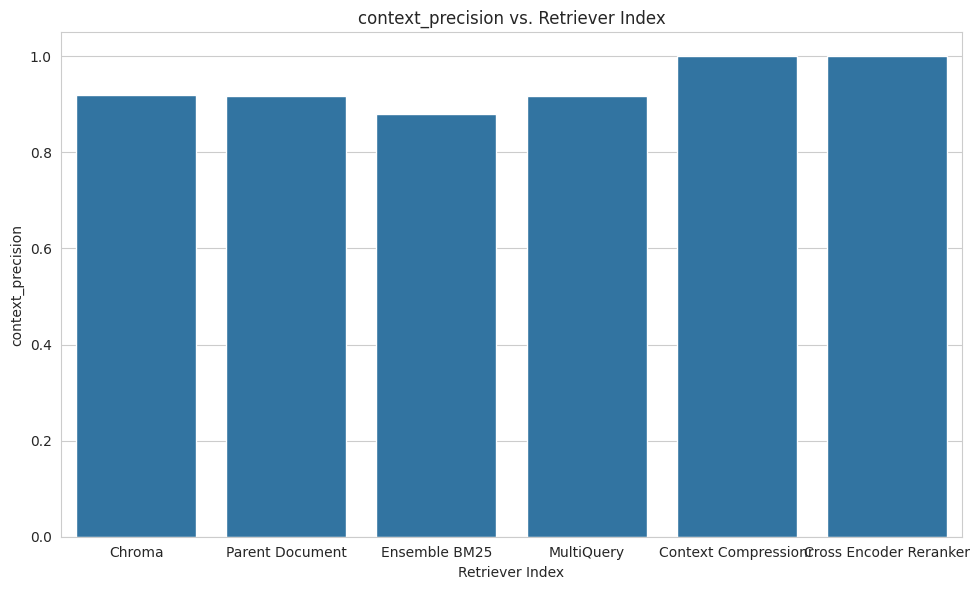

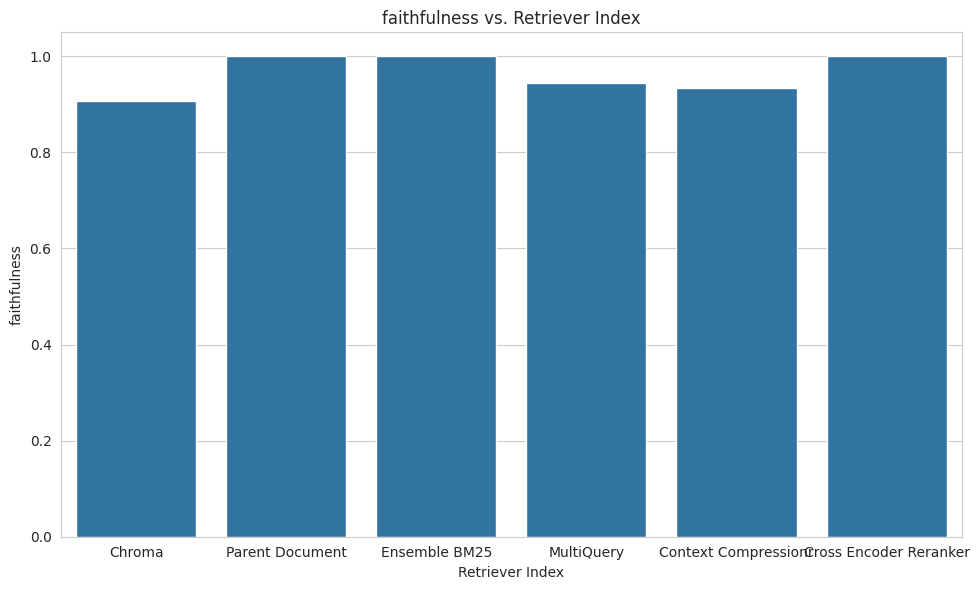

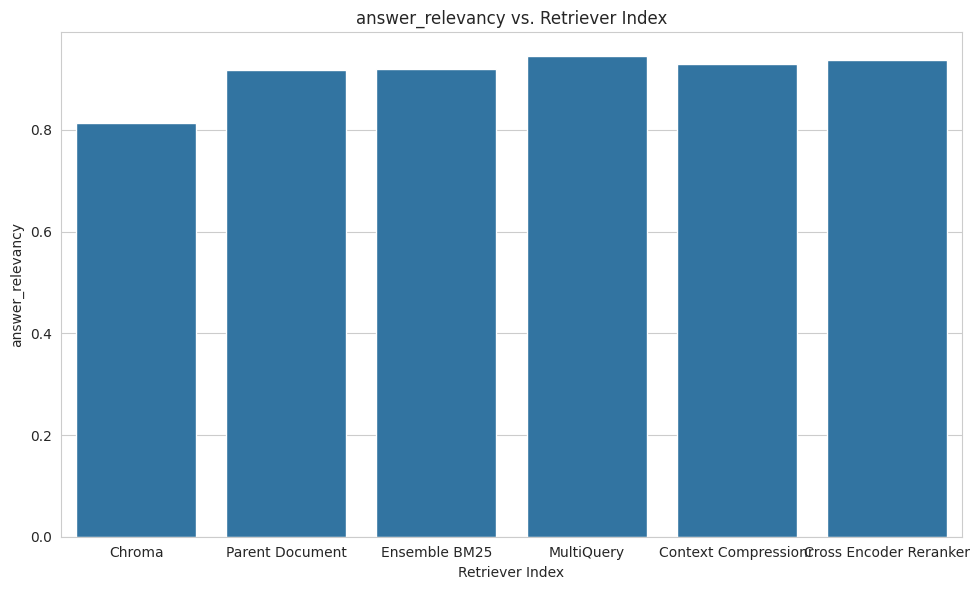

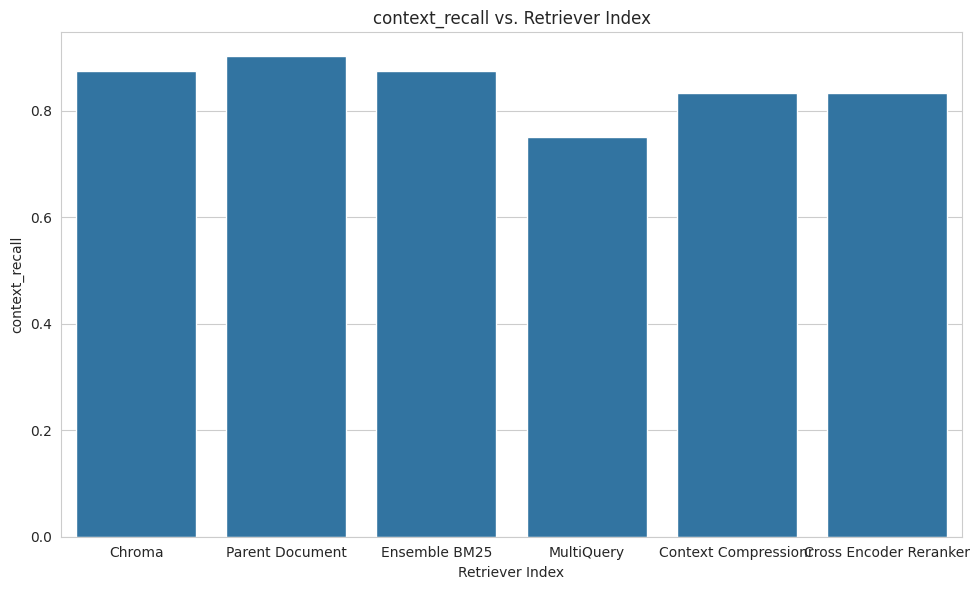

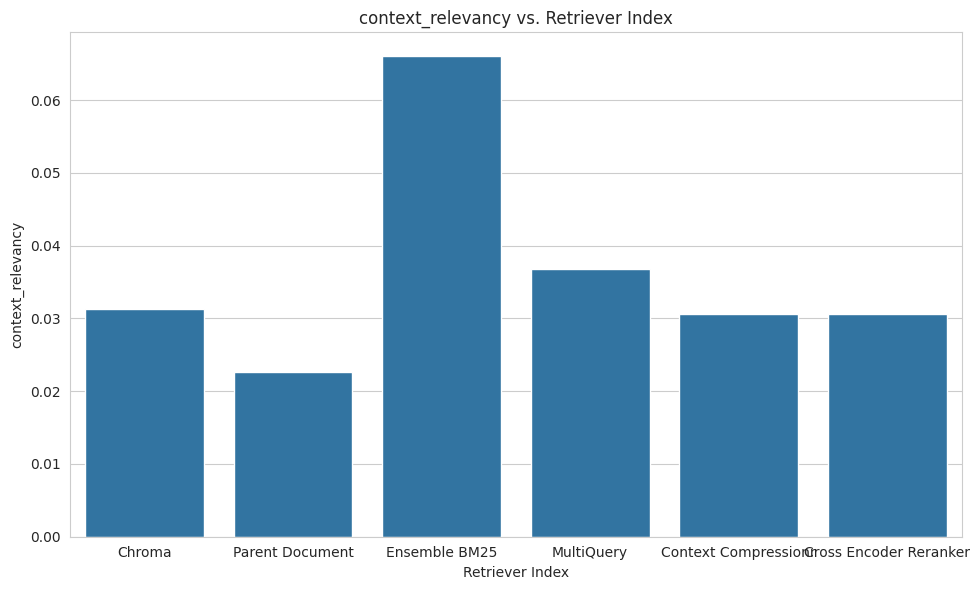

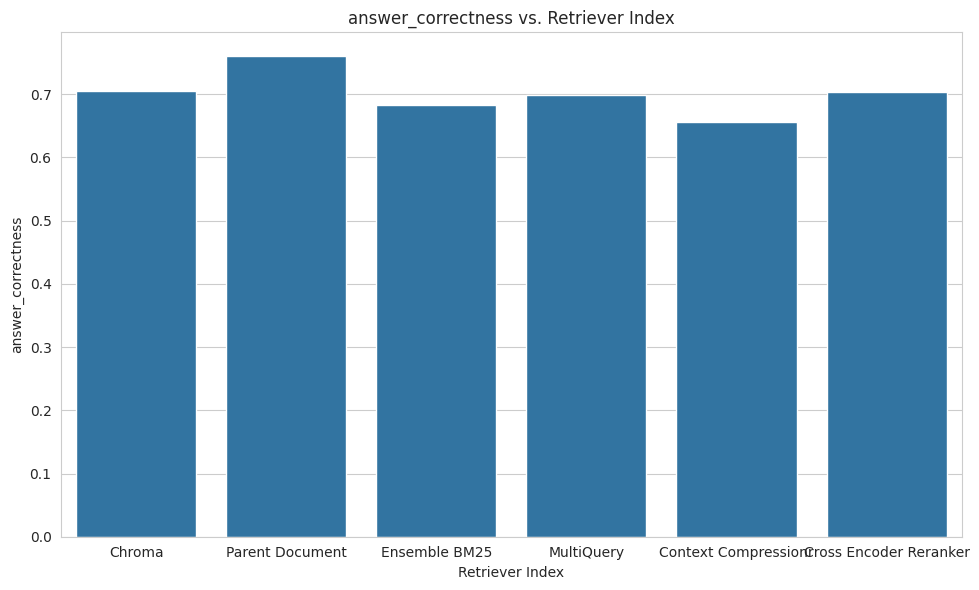

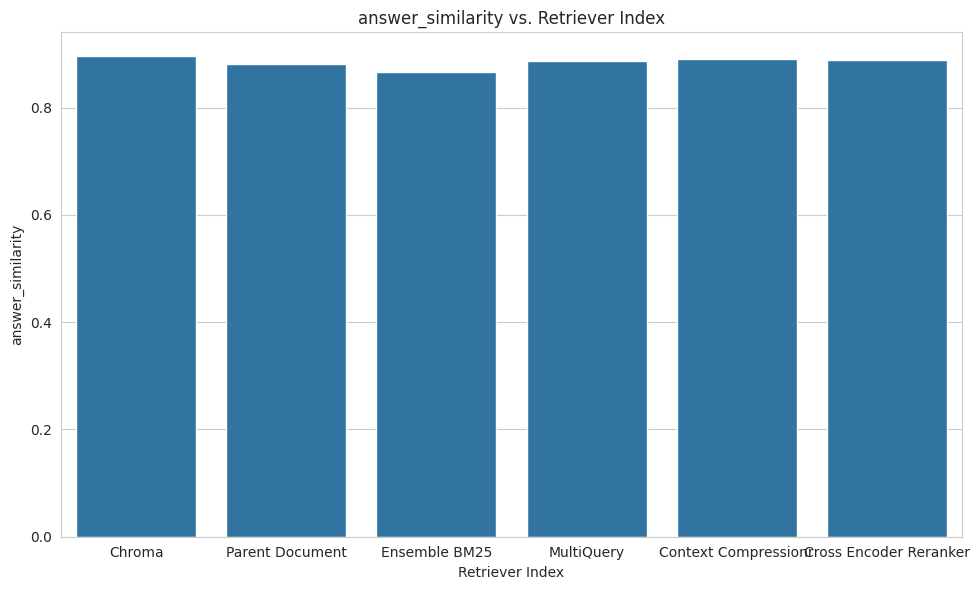

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = results_df

sns.set_style("whitegrid")

metrics = ['context_precision', 'faithfulness', 'answer_relevancy',
           'context_recall', 'context_relevancy', 'answer_correctness',
           'answer_similarity']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='name', y=metric, data=data)
    plt.title(f'{metric} vs. Retriever Index')
    plt.xlabel('Retriever Index')
    plt.ylabel(metric)
    plt.tight_layout()
    plt.savefig(f'{metric}_barplot.png')
    plt.show()


In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Read the CSV file into a DataFrame
# data = results_df

# # Set the style of seaborn
# sns.set_style("whitegrid")

# # Define color palette for different retrievers
# palette = sns.color_palette("husl", len(data))

# # Iterate over each metric and create bar plots
# metrics = ['context_precision', 'faithfulness', 'answer_relevancy',
#            'context_recall', 'context_relevancy', 'answer_correctness',
#            'answer_similarity']

# for metric in metrics:
#     plt.figure(figsize=(8, 4))
#     sns.barplot(x='name', y=metric, data=data, palette=palette)
#     plt.title(f'{metric} vs. Retriever Index')
#     plt.xlabel('Retriever Index')
#     plt.ylabel(metric)
#     plt.tight_layout()
#     plt.savefig(f'{metric}_barplot.png')  # Save the plot as an image
#     plt.show()


## Analysis

### 1. Context Precision
- **Chroma Retriever** scores highest with a context precision of approximately 0.92, indicating it's very effective in selecting relevant context that is useful for answering the posed questions.
- **Parent Document Retriever** and **MultiQuery Retriever** are close, both scoring around 0.916, suggesting they are also effective in retrieving useful contexts.
- **Ensemble BM25 Retriever** has the lowest context precision at about 0.88, which might suggest it includes some irrelevant context in its retrievals compared to others.
- Both **Context Compression Retriever** and **Cross Encoder Reranker** score a perfect approximate value of 1.0, indicating that they excel at selecting highly relevant context for the questions.

### 2. Faithfulness
- Both **Parent Document Retriever** and **Ensemble BM25 Retriever** score a perfect 1.0 in faithfulness, indicating that the contexts provided by these models are completely factual and support the answers derived from them.
- **MultiQuery Retriever** scores slightly lower at 0.94375, but still indicates high faithfulness.
- **Chroma Retriever** has the lowest faithfulness score at approximately 0.906, suggesting some room for improvement in ensuring factual alignment between context and answers.
- **Cross Encoder Reranker** achieves a perfect score of 1.0, suggesting that the contexts it retrieves are entirely factual and support the answers well.
- **Context Compression Retriever** has a slightly lower score at around 0.933, which is still high but indicates some room for improvement.


### 3. Answer Relevancy
- **MultiQuery Retriever** leads in answer relevancy with a score of about 0.944, indicating that it provides the most relevant and complete answers in relation to the questions.
- **Ensemble BM25 Retriever** follows closely with a score of approximately 0.920, showing strong performance in relevancy as well.
- **Parent Document Retriever** scores around 0.917, also showing good relevancy.
- **Chroma Retriever** has the lowest score at about 0.814, suggesting its answers may sometimes lack completeness or direct relevance to the questions.
- **Cross Encoder Reranker** has an answer relevancy score of approximately 0.938, showing strong performance in providing relevant and complete answers.
- **Context Compression Retriever** scores slightly lower at around 0.930, which is also quite high, indicating its answers are relevant to the questions.


### 4. Context Recall
- **Parent Document Retriever** scores the highest in context recall at approximately 0.902, which indicates it is particularly good at including context that contains information present in the ground truth answers.
- **Chroma Retriever** and **Ensemble BM25 Retriever** both have scores around 0.875, suggesting moderate performance.
- **MultiQuery Retriever** has the lowest context recall at 0.75, indicating it might miss some relevant details from the context that are present in the ground truth.
- Both models score 0.833 in context recall, which is the lowest among all the models discussed so far. This suggests that while the contexts they retrieve are very precise, they might sometimes miss some details that are present in the ground truth answers.

### 5. Answer Correctness
- **Parent Document Retriever** leads with a score of approximately 0.76, suggesting it is most effective at providing factually correct and semantically aligned answers with the ground truth.
- **Chroma Retriever** follows with a score of about 0.705.
- **MultiQuery Retriever** is slightly lower at approximately 0.698.
- **Ensemble BM25 Retriever** has the lowest score around 0.683, indicating room for improvement in this area.
- **Cross Encoder Reranker** leads slightly with a score of about 0.703, suggesting better factual correctness and semantic alignment with the ground truth.
- **Context Compression Retriever** has a score of approximately 0.656, indicating moderate performance in this area.

### 6. Answer Similarity
- **Chroma Retriever** excels in this metric with a score of approximately 0.896, suggesting a high degree of semantic resemblance between the answers it retrieves and the ground truth.
- **Parent Document Retriever** and **MultiQuery Retriever** follow closely with scores of about 0.882 and 0.886, respectively.
- **Ensemble BM25 Retriever** has the lowest score at about 0.866, which could indicate less semantic similarity compared to other models.
- **Context Compression Retriever** has a high answer similarity score of about 0.891, which is competitive with the top scores from the initial set of retrievers.
- **Cross Encoder Reranker** has a slightly lower score of about 0.888, but still indicates a high degree of semantic resemblance with the ground truth.

Overall, **Context Compression Retriever** and **Cross Encoder Reranker** excel in precision and faithfulness but may lack slightly in recall. Their performance in generating relevant and semantically similar answers is also impressive, making them strong candidates depending on the specific needs of the retrieval task, particularly where precision is prioritized over recall.